# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In this notebook we'll cover the transfer learning with 'Fine-tuning' in tensorflow. In this kind of tranfer learning the pre-trained model weights are unfrozen and tweaked during the training to better suit our own data.

## What we're going to cover

We're going to go through the follow with TensorFlow:

* Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data.

* Using the Keras Functional API (a differnt way to build models in Keras)
* Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
* Data augmentation (how to make your training dataset more diverse without adding more data)
* Running a series of modelling experiments on our Food Vision data
  * Model 0: a transfer learning model using the Keras Functional API
  * Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  * Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  * Model 3: a fine-tuned transfer learning model on 10% of the data
  * Model 4: a fine-tuned transfer learning model on 100% of the data
* Introduce the ModelCheckpoint callback to save intermediate training results
* Compare model experiments results using TensorBoard


## Creating Helper Functions
First, let's import the necessary python functionalities that we'll need thought this notebook. Accessible in my personal GitHub: https://github.com/Charliecr94/Tensor_flow_projects/blob/main/Extras/helper_functions.py







In [1]:
# Get helper_functions.py script from my GitHub
!wget https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-02-16 23:37:14--  https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2023-02-16 23:37:14 (117 MB/s) - ‘helper_functions.py’ saved [10234/10234]



## Preparing the data (Food vision APP).

In [2]:
# Get 10% of the data of the 10 classes.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-02-16 23:37:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2023-02-16 23:37:20 (159 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [5]:
import tensorflow as tf
IMG_SIZE = (224,224)
batch_size = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size= IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size= batch_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size= batch_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[152.7296     91.72959    70.72959  ]
   [149.59183    88.591835   67.591835 ]
   [151.07143    90.07143    69.07143  ]
   ...
   [ 17.704075   20.704075   25.704075 ]
   [ 14.2142725  18.239788   19.020359 ]
   [ 13.255127   18.255127   13.5407715]]

  [[154.21428    92.21429    69.21429  ]
   [151.08163    89.08163    66.08163  ]
   [153.         91.         68.       ]
   ...
   [ 29.714266   34.714264   38.714264 ]
   [ 29.214262   34.352028   36.92852  ]
   [ 22.453981   28.453981   25.647795 ]]

  [[155.64796    90.43367    68.43367  ]
   [157.65817    92.44388    70.44388  ]
   [155.61736    90.40306    68.40306  ]
   ...
   [ 35.117344   43.545914   46.285713 ]
   [ 33.34182    41.770393   43.770393 ]
   [ 29.362219   38.07143    39.152973 ]]

  ...

  [[228.        192.        158.56123  ]
   [228.92857   192.92857   157.07143  ]
   [229.38263   193.76527   157.       ]
   ...
   [210.85706   194.85706   169.85706  ]
   [207.48466   191.48466   166.48466  ]
   [2

## Model 0: Building a transfer learning model using the Keras Functional API.

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more f


In [8]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs.
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x= base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model.
model_0.compile(loss= "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch= len(train_data_10_percent),
                                 validation_data= test_data,
                                 validation_steps= int(0.25*len(test_data)),
                                 callbacks= [create_tensorboard_callback(dir_name= 'transfer_learning',
                                                                         experiment_name= '10_percent_feature_extraction')])

16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230216-233729
Epoch 1/5
24/24 [==============================] - 22s 349ms/step - loss: 1.9264 - accuracy: 0.4120 - val_loss: 1.3244 - val_accuracy: 0.7533
Epoch 2/5
24/24 [==============================] - 5s 173ms/step - loss: 1.1115 - accuracy: 0.7613 - val_loss: 0.8778 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 4s 135ms/step - loss: 0.7967 - accuracy: 0.8240 - val_loss: 0.6957 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 4s 134ms/step - loss: 0.6405 - accuracy: 0.8613 - val_loss: 0.6177 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 5s 197ms/step - loss: 0.5405 - accuracy: 0.8907 - val_loss: 0.5697 - val_accuracy: 0.8487


In [9]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5513 - accuracy: 0.8648


[0.5513464212417603, 0.864799976348877]

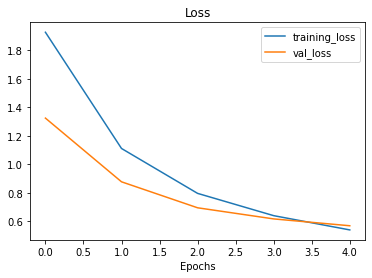

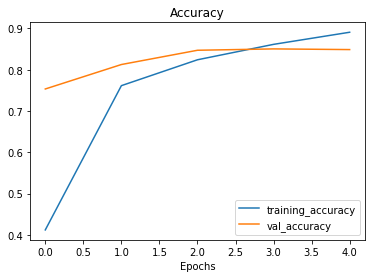

In [10]:
plot_loss_curves(history_10_percent)

Wooah, that lots good!, 

Before trying to improve this model, lets make some experiments.

## Getting a feature vector from a trained model.

In [11]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")
     

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


Here we can how the `tf.keras.layers.GlobalAveragePooling2D() `layer condensed the `input tensor` from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the input_tensor across the middle two axes.

## Testing the Edges of trafer learning with some experiments.

With 10% of the validation data we reach some prominent results, what happen if we try with ONLY 1%?

In [12]:
# Dowload and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2023-02-16 23:38:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   262MB/s    in 0.5s    

2023-02-16 23:38:27 (262 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [13]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"  


In [14]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [15]:
# Setup data loaders.
IMG_SIZE = (224,224)
BATCH_SIZE= 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode= 'categorical',
                                                                           image_size= IMG_SIZE,
                                                                           batch_size= BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode= 'categorical',
                                                                           image_size= IMG_SIZE,
                                                                           batch_size= BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 70 files belonging to 10 classes.


#### Adding data augmentation right into the model.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation state.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
], name='data_augmentation')

Let's visualize some of the augmentation data, that way we can see what are really happen with our images.

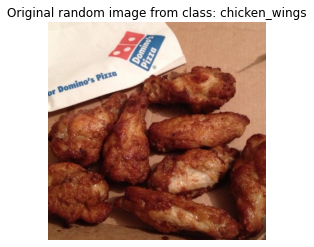

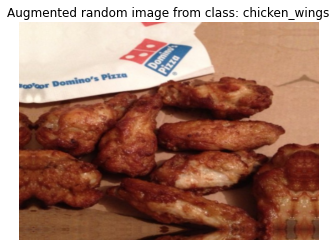

In [17]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Model_1 : Feature extraction with just a 1% of the train_data with data augmentation.

In [18]:
# Setup input shape and base model, freezing the base model layers.
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape= input_shape, name = 'input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output.
outputs = layers.Dense(10, activation = 'softmax', name='output_layer')(x)

# Make a model using the inputs and outputs.
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                 epochs=5,
                                 steps_per_epoch= len(train_data_1_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25* len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name= 'transfer_learning',
                                                                                                 experiment_name = '1_percent_data_aug')])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230216-233837
Epoch 1/5


3/3 [==============================] - 14s 3s/step - loss: 2.3500 - accuracy: 0.1000 - val_loss: 2.2068 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.0995 - accuracy: 0.3143 - val_loss: 2.0973 - val_accuracy: 0.2220
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9068 - accuracy: 0.4286 - val_loss: 1.9824 - val_accuracy: 0.3207
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7220 - accuracy: 0.5714 - val_loss: 1.8996 - val_accuracy: 0.3783
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5867 - accuracy: 0.6571 - val_loss: 1.8068 - val_accuracy: 0.4655


In [19]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [20]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 79ms/step - loss: 1.8011 - accuracy: 0.4692


[1.8010880947113037, 0.4691999852657318]

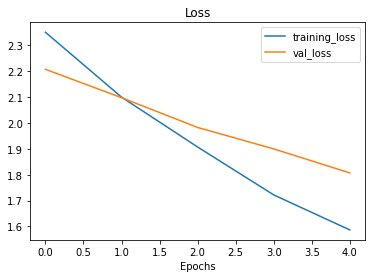

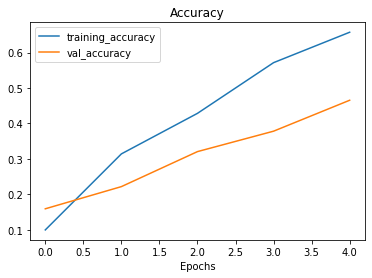

In [21]:
# How dows the model with 1% of the and data augmentation loss curves lock?
plot_loss_curves(history_1_percent)

### Model_2: feature extration tranfer learning model with 10% of the data.

In [22]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2023-02-16 23:39:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.159.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   225MB/s    in 0.7s    

2023-02-16 23:39:20 (225 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [23]:
# Set data inputs
import tensorflow as tf
IMG_SIZE= (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [24]:
# Create model 2 with data augmetation built in
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])
     

In [25]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

### Create a Model Checkpoint

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there

In [26]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False, 
                                                         save_freq="epoch", 
                                                         verbose=1)
     

### Fit model 2 passing in the ModelCheckpoint Callback.

In [27]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230216-233928


Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9618 - accuracy: 0.3813
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 639ms/step - loss: 1.9618 - accuracy: 0.3813 - val_loss: 1.3835 - val_accuracy: 0.7401
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2946 - accuracy: 0.7053
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 587ms/step - loss: 1.2946 - accuracy: 0.7053 - val_loss: 0.9462 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9985 - accuracy: 0.7507
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 516ms/step - loss: 0.9985 - accuracy: 0.7507 - val_loss: 0.7276 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.8013
Epoch

In [28]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 73ms/step - loss: 0.6075 - accuracy: 0.8532


[0.6074610352516174, 0.8532000184059143]

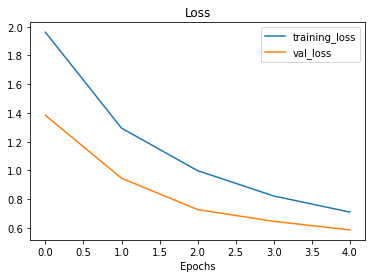

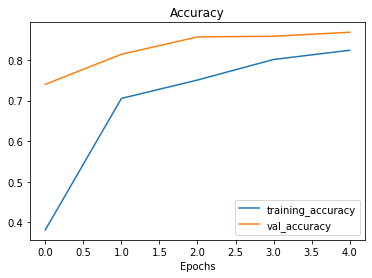

In [29]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [30]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6075 - accuracy: 0.8532


this looks promising, because apparently if we continue training the model for more epochs, it will improve, soo lets load the model too continue his training, but this time we'll add fine-tuning.


### Model_3 : Fine-Tuning with 10% of the Data.

In [31]:
# Layers in loaded model
model_2.layers

In [32]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4c9e79ff10> True
<keras.engine.sequential.Sequential object at 0x7f4caa177fa0> True
<keras.engine.functional.Functional object at 0x7f4ca9ec3c40> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f4caa2fc4c0> True
<keras.layers.core.dense.Dense object at 0x7f4c9b72ac70> True


In [33]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


Beautiful! the base model wasn't training his layers until know, for transfer Fine-tuning we'll unfroze his lasts 10 layers.

In [34]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [35]:

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [36]:
# Now we've unfrozen some of the layer closer to the top, so how many trainable variabels are there?
print(len(model_2.trainable_variables))

12


In [37]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230216-234122
Epoch 5/10


24/24 [==============================] - 27s 632ms/step - loss: 0.6960 - accuracy: 0.7800 - val_loss: 0.4589 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - 12s 442ms/step - loss: 0.3903 - accuracy: 0.8800 - val_loss: 0.4280 - val_accuracy: 0.8635
Epoch 7/10
24/24 [==============================] - 11s 426ms/step - loss: 0.1922 - accuracy: 0.9413 - val_loss: 0.4414 - val_accuracy: 0.8651
Epoch 8/10
24/24 [==============================] - 12s 459ms/step - loss: 0.1791 - accuracy: 0.9453 - val_loss: 0.4070 - val_accuracy: 0.8734
Epoch 9/10
24/24 [==============================] - 11s 450ms/step - loss: 0.1190 - accuracy: 0.9640 - val_loss: 0.4607 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0849 - accuracy: 0.9813 - val_loss: 0.4907 - val_accuracy: 0.8684


In [38]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)
     

79/79 [==============================] - 6s 64ms/step - loss: 0.4996 - accuracy: 0.8552


Alrigth, now we need a way to evaluate our model's performance before and after fine-tuning, soo lets write a function that can help with that.

In [39]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3813333213329315, 0.7053333520889282, 0.7506666779518127, 0.8013333082199097, 0.8240000009536743, 0.7799999713897705, 0.8799999952316284, 0.9413333535194397, 0.9453333616256714, 0.9639999866485596, 0.981333315372467]


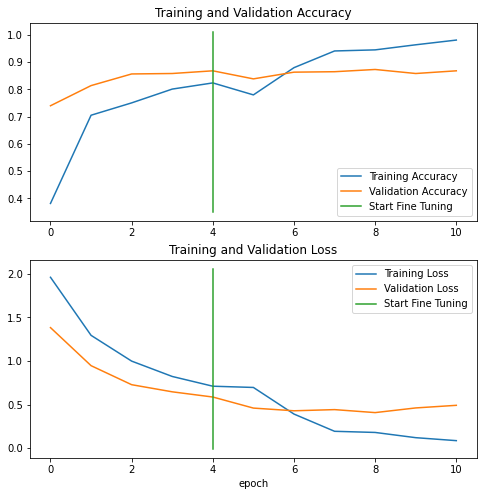

In [40]:
# Comparing the before and after of the fine tuning

compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

### Model_4: Fine-tuning and existing model on all of the data.

The time has come,  now we will  implement Fine-tuning with all available data.

In [42]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-02-16 23:43:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  80.3MB/s    in 5.2s    

2023-02-16 23:43:28 (96.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [43]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [44]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

In [45]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.4996 - accuracy: 0.8552


[0.4996334910392761, 0.8551999926567078]

In [46]:
results_fine_tune_10_percent

[0.4996333122253418, 0.8551999926567078]

To train a fine-tuning model to 100% (`mode_4`) we need to revert `model_2` back to its feature extraction weights.

In [47]:
model_2.load_weights(filepath=checkpoint_path)

ValueError: ignored

In [48]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.6075 - accuracy: 0.8532


[0.6074609160423279, 0.8532000184059143]

In [49]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6074610352516174, 0.8532000184059143]

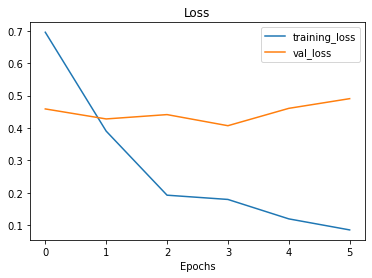

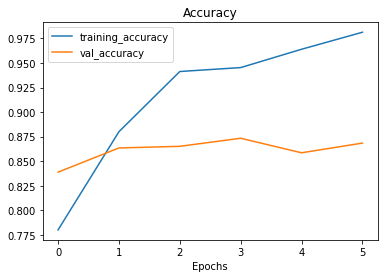

In [50]:
# Check to see if our model_2 has been reverted back to feature extraction results
plot_loss_curves(history_fine_10_percent_data_aug)

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [51]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [52]:
# compile
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics= ["accuracy"])

In [53]:
# continue to train and fine-tune the model to our data
initial_epoch = 5

fine_tune_epochs = initial_epoch + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs= fine_tune_epochs,
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           validation_data = test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           callbacks= [create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230216-234419
Epoch 5/10


235/235 [==============================] - 98s 369ms/step - loss: 0.6566 - accuracy: 0.7880 - val_loss: 0.3026 - val_accuracy: 0.9062
Epoch 6/10
235/235 [==============================] - 81s 343ms/step - loss: 0.5168 - accuracy: 0.8339 - val_loss: 0.2617 - val_accuracy: 0.9079
Epoch 7/10
235/235 [==============================] - 77s 327ms/step - loss: 0.4719 - accuracy: 0.8451 - val_loss: 0.2574 - val_accuracy: 0.9178
Epoch 8/10
235/235 [==============================] - 75s 317ms/step - loss: 0.4249 - accuracy: 0.8632 - val_loss: 0.2432 - val_accuracy: 0.9243
Epoch 9/10
235/235 [==============================] - 70s 295ms/step - loss: 0.3857 - accuracy: 0.8776 - val_loss: 0.2158 - val_accuracy: 0.9276
Epoch 10/10
235/235 [==============================] - 71s 300ms/step - loss: 0.3561 - accuracy: 0.8872 - val_loss: 0.2365 - val_accuracy: 0.9128


5
11
[0.3813333213329315, 0.7053333520889282, 0.7506666779518127, 0.8013333082199097, 0.8240000009536743, 0.7879999876022339, 0.8338666558265686, 0.8450666666030884, 0.8632000088691711, 0.8776000142097473, 0.8871999979019165]


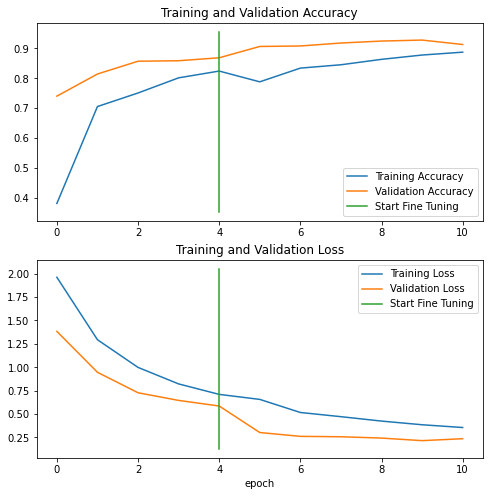

In [54]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.